In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

N_Threads = "4"

Welcome to JupyROOT 6.22/02


In [2]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=True):
    Histo = ROOT.TH1F(Title,Title,nbins,xmin,xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv=ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name=Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [5]:
#name='gold_47_SC_90m_211220'
#name.split('_')
#
#angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
#
#file=open('gold_47_SC_90m_211220/Stat_gold_47_SC_90m_211220.txt')
#line=file.readlines()
#for l in line:
#    if (l.startswith("Readout_time")):
#        time=float(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Strobe")):
#        Strobe=int(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Gap")):
#        Gap=int(l.split('=')[1].strip()[:-1])
#        
#weight=3600*(Gap+Strobe)/(Strobe*time)
#
#os.system("python Packet_analyzer.py -f gold_47_SC_90m_211220 -p -A DB -d 1 10 -b 1000 -s %i -w %f " % (angle,weight))


# Analysis on a specific dataset

In [6]:
files=os.listdir('Data/')
for name in files:
    if name.startswith("gold_11"):
        angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)

        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
                
        #weight that gives count/hour
        weight=3600*(Gap+Strobe)/(Strobe*time)

        os.system("python Packet_analyzer.py -Df Data -f " + name + " -p -A DB -d 1 10 -b 1000 -NThr " + N_Threads + " -s %i -w %f " % (angle,weight))

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0
gold_11_SC_150m_221220: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [7]:
! $ROOTSYS/bin/hadd Tot_63_2.root Analyzed_Data/gold_*/*.root

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0
hadd Target file: Tot_63_2.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/gold_11_SC_150m_221220/gold_11_SC_150m_221220.root
hadd Source file 2: Analyzed_Data/gold_13_SC_60m_221220/gold_13_SC_60m_221220.root
hadd Source file 3: Analyzed_Data/gold_15_SC_90m_221220/gold_15_SC_90m_221220.root
hadd Source file 4: Analyzed_Data/gold_17_DC_30m_run1_251220/gold_17_DC_30m_run1_251220.root
hadd Source file 5: Analyzed_Data/gold_17_DC_30m_run2_251220/gold_17_DC_30m_run2_251220.root
hadd Source file 6: Analyzed_Data/gold_17_DC_30m_run3_251220/gold_17_DC_30m_run3_251220.root
hadd Source file 7: Analyzed_Data/gold_17_DC_30m_run4_251220/gold_17_DC_30m_run4_251220.root
hadd Source file 8: Analyzed_Data/gold_17_DC

# Analysis with normalization (time and Strobe parameters)

In [3]:
#normalization array from -180° to 180° [steps]
ALPIDE_norm=np.zeros(201)
Data_folder="Data"

Run_Analysis = True

#load files of a cartain dataset
files=os.listdir(Data_folder + "/")
for name in files:
    if name.startswith("gold_alpide"):
        #for gold_ files
        #angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
        # for gold_alpide files
        angle=int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)
        file=open(Data_folder+"/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
                
        #weight that gives effective exposition time [hours]
        weight=3600*(Gap+Strobe)/(Strobe*time)
        
        #compute the normalization parameter
        for i in range(angle-29,angle-4):
            ALPIDE_norm[100+i] += 1/weight

        #analyze the data
        #os.system("python Packet_analyzer.py -f " + name + " -p -b 1000 -s %i -w %f" % (angle,weight))
        if Run_Analysis:
            Args = "-Df "+Data_folder+" -f "+name+" -p -A DB -NThr "+N_Threads+" -b 1000 -s %i -w %f "%(angle,weight)
            %run 'Packet_analyzer.py' {Args}  

gold_alpide_53_SC_240m_run5_020121: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


In [4]:
#merge all the TTree
! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_Alide_53SC.root Analyzed_Data/gold_alpide*/*.root 

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0
hadd Target file: Tot_data_tree/Tot_Alide_53SC.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/gold_alpide_53_SC_240m_run10_020121/gold_alpide_53_SC_240m_run10_020121.root
hadd Source file 2: Analyzed_Data/gold_alpide_53_SC_240m_run1_020121/gold_alpide_53_SC_240m_run1_020121.root
hadd Source file 3: Analyzed_Data/gold_alpide_53_SC_240m_run11_020121/gold_alpide_53_SC_240m_run11_020121.root
hadd Source file 4: Analyzed_Data/gold_alpide_53_SC_240m_run12_020121/gold_alpide_53_SC_240m_run12_020121.root
hadd Source file 5: Analyzed_Data/gold_alpide_53_SC_240m_run2_020121/gold_alpide_53_SC_240m_run2_020121.root
hadd Source file 6: Analyzed_Data/gold_alpide_53_SC_240m_run3_020121/gold_alpide_53_SC_240m_run3

In [5]:
#ROOT.enableJSVis()
ROOT.disableJSVis()

#convert the TTree in np arrays
root_file_1  =ROOT.TFile.Open("Tot_data_tree/Tot_Alide_53SC.root")
Data_tree    = root_file_1.Get("tree")
#Data_tree.Print()

Noise_points = Data_tree.AsMatrix(['Rnoise'])
Areas        = Data_tree.AsMatrix(['Rareas'])
Means        = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Theta        = Data_tree.AsMatrix(['Rtheta'])
Weight       = Data_tree.AsMatrix(['Rweight'])
Ratios       = Data_tree.AsMatrix(['Rratios'])

504.6372765176068 261.12751534927355


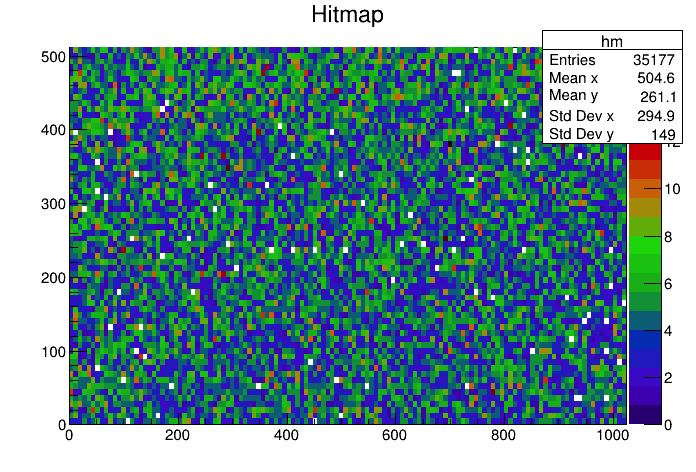

In [6]:
hm = ROOT.TH2D('hm','Hitmap',128,0,1024,64,0,512)

for coordinate in Means:
    hm.Fill(coordinate[0],coordinate[1])
    
ROOT.gStyle.SetPalette(107)
    
HC=ROOT.TCanvas()
hm.Draw('COLZ')
HC.Draw()

print(np.mean(Means[:,0]), np.mean(Means[:,1]))

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created


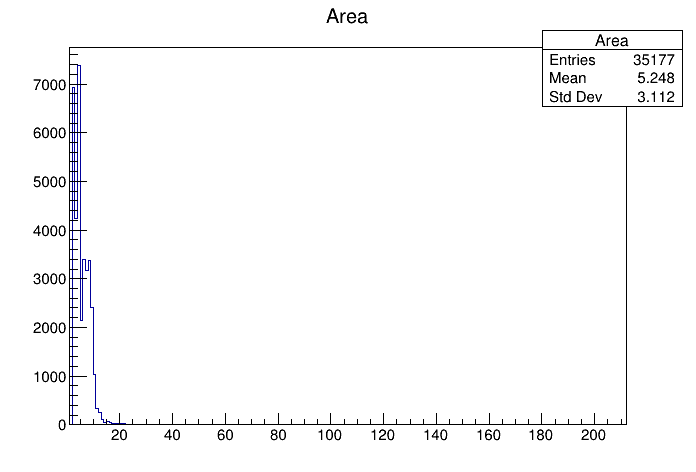

In [7]:
ar_max=int(np.amax(Areas))
nbins=int((ar_max-1))
arHist,AC=make_histo(Areas,'Area',nbins,1,ar_max)
AC.Draw()

Warning in <TFile::Append>: Replacing existing TH1: Area (Potential memory leak).
Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created
Info in <TCanvas::Print>: pdf file PCA_Ratio_Histo.pdf has been created


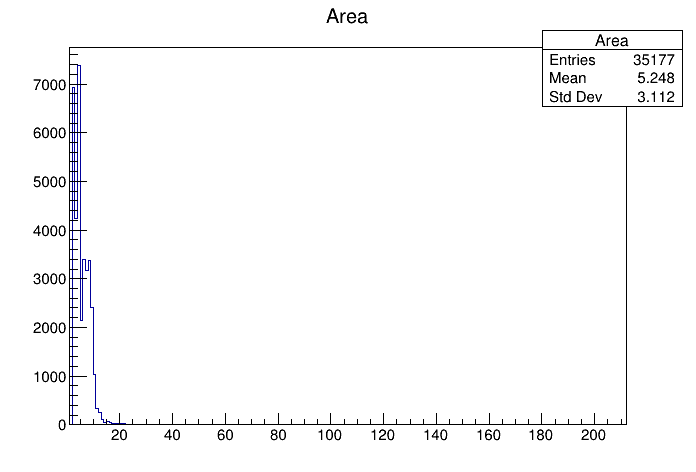

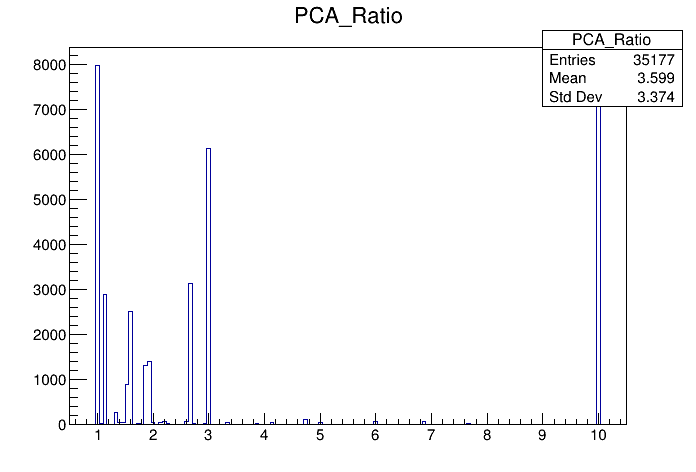

In [8]:
ar_max=int(np.amax(Areas))
nbins=int((ar_max-1))
ArHist,AC=make_histo(Areas,'Area',nbins,1,ar_max)
AC.Draw()

r_max=(np.amax(Ratios)+0.5)
nbins=150
RHist,RC=make_histo(Ratios,'PCA_Ratio',nbins,0.5,r_max)
RC.Draw()

In [9]:
Area_thr=19
Ratio_thr=3

xmin = 10
xmax = 1013
ymin = 10 
ymax = 490


mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )

mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))


Areas_disc  = Areas [mask]
Means_disc  = Means [mask]
Theta_disc  = Theta [mask]
Weight_disc = Weight[mask]
Ratios_disc = Ratios[mask]


#A_disc_index = np.where  (Areas<Area_thr)
#Areas_disc   = np.delete (Areas ,A_disc_index)
#Means_disc   = np.delete (Means ,A_disc_index,axis=0)
#Theta_disc   = np.delete (Theta ,A_disc_index)
#Weight_disc  = np.delete (Weight,A_disc_index)
#Ratios_disc  = np.delete (Ratios,A_disc_index)

#R_disc_index=np.where (Ratios_disc>Ratio_thr)
#Areas_disc  =np.delete(Areas_disc,R_disc_index)
#Means_disc  =np.delete(Means_disc,R_disc_index,axis=0)
#Theta_disc  =np.delete(Theta_disc,R_disc_index)
#Weight_disc =np.delete(Weight_disc,R_disc_index)
#Ratios_disc =np.delete(Ratios_disc,R_disc_index)

Info in <TCanvas::Print>: png file Graph_images/Theta_histo.png has been created


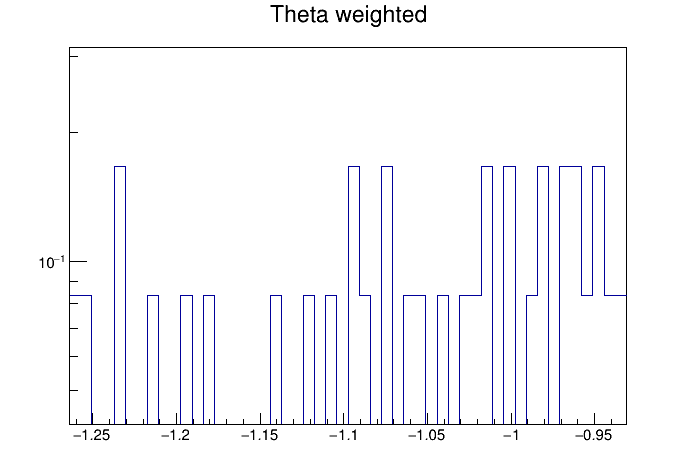

In [10]:
th_max = (np.amax(Theta_disc))
th_min = (np.amin(Theta_disc))
nbins  = 50

ThHist = ROOT.TH1F('ThHist', 'Theta weighted',nbins,th_min,th_max)

alpide_data   = []
alpide_weight = []

for value,weight in zip(Theta_disc,Weight_disc):
    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    ThHist.Fill(value,1/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    alpide_data.append(value*180/np.pi)
    alpide_weight.append(1/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    #ThHist.Fill(value,weight)
    
ThHist.SetStats(False)
alpide_data   = np.array(alpide_data  )
alpide_weight = np.array(alpide_weight)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()
TC.Print('Graph_images/Theta_histo.png')

Warning in <TFile::Append>: Replacing existing TH1: Area (Potential memory leak).
Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created
Info in <TCanvas::Print>: png file Area_histo.png has been created
Info in <TCanvas::Print>: pdf file Ratios_Histo.pdf has been created


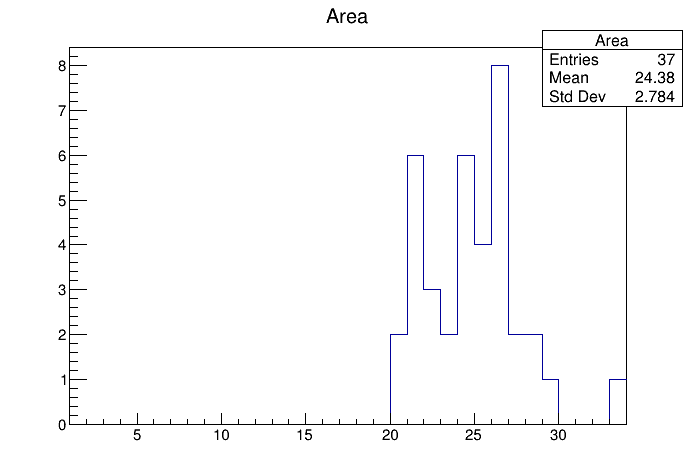

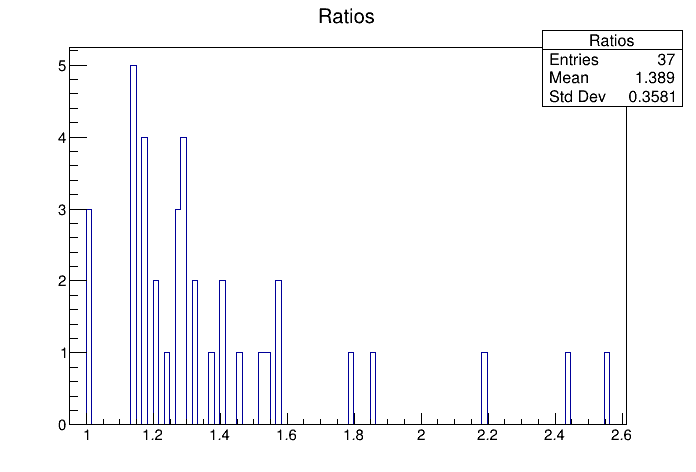

In [11]:
ar_max = int(np.amax(Areas_disc))
nbins  = int(ar_max)

ArHist,AC=make_histo(Areas_disc,'Area',nbins,1,ar_max+1)
AC.Draw()
AC.Print('Area_histo.png')

r_max   = np.amax(Ratios_disc)
nbins   = 100


RHist,RC=make_histo(Ratios_disc,'Ratios',nbins,0.95,r_max+0.05)
RHist.Draw()
RC.Draw()


#MxHist = ROOT.TH1F('MxHist', 'X Means',16,0,1023)
#
#for value in Means_disc[:,0]:
#    MxHist.Fill(value)
#
#MxC=ROOT.TCanvas()
#MxHist.Draw()
#MxC.Draw()

## Compare with simulation

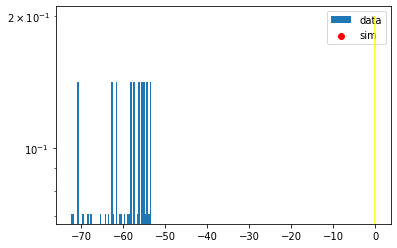

In [12]:
alpide_sim= np.loadtxt("../../../simulations/notebook/AlpideHistoSim.txt")
alpide_sim= alpide_sim[np.logical_and(alpide_sim[:,0]>min(alpide_data),alpide_sim[:,0]<max(alpide_data))]

norm = np.sum(alpide_sim)*(alpide_sim[1,0]-alpide_sim[0,0])

plt.hist(alpide_data, weights=alpide_weight, bins=50, density=True, label="data")
plt.scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
plt.vlines(0,0,0.2, color='yellow', zorder=10000)
plt.yscale("log")
plt.legend()

# THR analysis
* Noise vs VCASN
* Area vs PCA ratio 2D Histo

In [18]:
#Run packet analyzer script for all threshold
Data_folder_path="Data"
files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        #analyze the data
        args = "-f "+name+" -Df "+Data_folder_path+" -d 1 10 "
        %run 'Packet_analyzer.py' {args}

In [27]:
#Noise dependace on VCASN

VCASN_val    = []
Noise_points = []


files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        V_CASN_THR=int(name.split('_')[2], base=16)
        VCASN_val = np.append(VCASN_val,V_CASN_THR)
        
        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
        
        filename="Analyzed_Data/"+name+"/"+name+".root"
        root_file_1  = ROOT.TFile.Open(filename)
        Data_tree    = root_file_1.Get("tree")
        Noise        = Data_tree.AsMatrix(['Rnoise'])
        Noise_points = np.append(Noise_points,Noise[0]*(Strobe+Gap)/(time*Strobe))
        

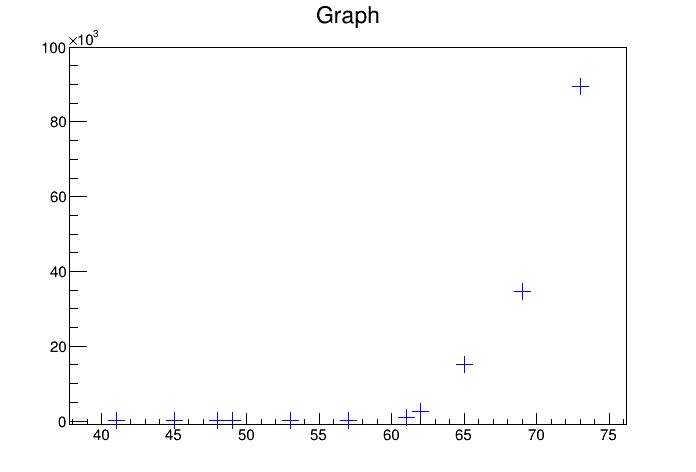

In [28]:
#plt.plot(VCASN_val,Noise_points, 'bo')
Noise_graph = ROOT.TGraph(len(Noise_points),VCASN_val,Noise_points)

Noise_graph.SetMarkerColor(4)
Noise_graph.SetMarkerStyle(2)
Noise_graph.SetMarkerSize(2)
YAxis = Noise_graph.GetYaxis()
YAxis.SetRangeUser(-1000,100000)

NPC = ROOT.TCanvas()

Noise_graph.Draw('AP')
NPC.Draw()

In [31]:
#convert the TTree in np arrays
name        = "gold_17_DC_30m_run1_251220"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

Areas  = Data_tree.AsMatrix(['Rareas'])
Means  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios = Data_tree.AsMatrix(['Rratios'])

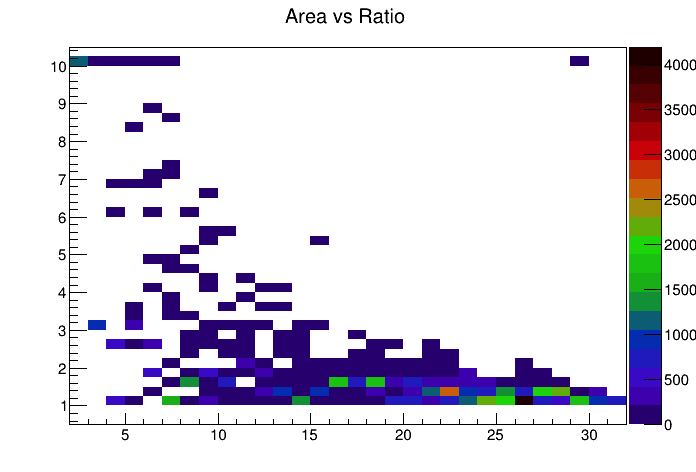

In [32]:
ar_max=int(np.amax(Areas))
A_R_Histo = ROOT.TH2D('A_R_Histo','Area vs Ratio',ar_max-2,2,ar_max,40,0.5,10.5)

for i in range(len(Areas)):
    A_R_Histo.Fill(Areas[i],Ratios[i])
    
    
ARC=ROOT.TCanvas()
A_R_Histo.Draw("COLZ")
A_R_Histo.SetStats(False)
ARC.Draw()